In [114]:
%pylab inline
import hydra
from volt.util import ddict
from pathlib import Path
import io
import pickle
from matplotlib import pyplot as plt

method = 'pca_unconditional'
import torch


class CPUUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


def load_data(run_id):
    path = Path('../data/models/checkpoints', run_id, 'embeddings.pkl')

    feature_bank, feature_labels, embedding, targets, label_names = CPUUnpickler(open(path, 'rb')).load()

    path_unnorm = Path('../data/models/checkpoints', run_id, 'embeddings_unnorm.pkl')
    feature_bank_unnorm, embedding_unnorm = CPUUnpickler(open(path_unnorm, 'rb')).load()

    return ddict(train_embeddings_norm=feature_bank, train_labels=feature_labels, val_embeddings_norm=embedding,
                 val_labels=targets, label_names=label_names, train_embeddings=feature_bank_unnorm,
                 val_embeddings=embedding_unnorm)

hydra.initialize("../conf_ensembling", version_base='1.1')
from volt import linear_probe
cfg = hydra.compose(config_name='c100_fixed.yaml')

datas = [load_data(run_id) for run_id in cfg.run_ids]
assert all([data['label_names'] == datas[0]['label_names'] for data in datas])

assert all([torch.all(data['train_labels'] == datas[0]['train_labels']) for data in datas])
assert all([torch.all(data['val_labels'] == datas[0]['val_labels']) for data in datas])
label_names = datas[0]['label_names']
train_labels = datas[0]['train_labels']
val_labels = datas[0]['val_labels']

train_embeddings = [data['train_embeddings'].T for data in datas]
val_embeddings = [data['val_embeddings'] for data in datas]
train_embeddings_norm = [data['train_embeddings_norm'].T for data in datas]
val_embeddings_norm = [data['val_embeddings_norm'] for data in datas]

train_cluster_assignments = torch.tensor(torch.load('output_clustersB.pt'))
gm = torch.load('output_gmB.pt')
A, U, S, V, E = torch.load('output_pcaB.pt')
# train_cluster_assignments = torch.tensor(torch.load('output_clustersK.pt'))
# gm = torch.load('output_gmK.pt')
# A, U, S, V, E = torch.load('output_pcaK.pt')

def assign(embeddings):
    embs = ((embeddings - A.mean(axis=0)) @ V @ torch.diag(1 / S)).cpu().numpy()
    predictions = gm.predict(embs)
    return torch.tensor(predictions)

# import pdb; pdb.set_trace()
assert torch.all(assign(train_embeddings_norm[0]) == train_cluster_assignments)

val_cluster_assignments = assign(val_embeddings_norm[0])

Populating the interactive namespace from numpy and matplotlib


ValueError: GlobalHydra is already initialized, call GlobalHydra.instance().clear() if you want to re-initialize

In [127]:
if method == 'pca_unconditional':
    train_ensemble_embeddings_raw = torch.cat(train_embeddings, dim=1)
    val_ensemble_embeddings_raw = torch.cat(val_embeddings, dim=1)

    U, S, V = torch.pca_lowrank(train_ensemble_embeddings_raw, q=100, niter=10)
    train_ensemble_embeddings = U

    train_ensemble_embeddings_centered = train_ensemble_embeddings_raw - train_ensemble_embeddings_raw.mean(axis=0)

    R = train_ensemble_embeddings_centered @ V @ torch.diag(1 / S)
    assert torch.all((U - R).pow(2).sum(1).sqrt() < 1e-4)

    val_ensemble_embeddings_centered = val_ensemble_embeddings_raw - train_ensemble_embeddings_raw.mean(axis=0)
    val_ensemble_embeddings = (val_ensemble_embeddings_centered @ V @ torch.diag(1 / S))
elif method == 'pca_conditional':
    train_ensemble_embeddings_raw = torch.cat(train_embeddings, dim=1)
    val_ensemble_embeddings_raw = torch.cat(val_embeddings, dim=1)


    spl = train_embeddings[0].shape[1]
    # zero out the embeddings of each cluster on the data points that do not belong to that cluster
    for i, cluster in enumerate(cfg.cluster_ids):
        fro = (i + 1) * spl
        to = (i + 2) * spl
        train_ensemble_embeddings_raw[train_cluster_assignments != cluster, fro:to] = 0
        val_ensemble_embeddings_raw[val_cluster_assignments != cluster, fro:to] = 0

    U, S, V = torch.pca_lowrank(train_ensemble_embeddings_raw, q=train_embeddings[0].shape[1], niter=10)
    train_ensemble_embeddings = U

    val_ensemble_embeddings_centered = val_ensemble_embeddings_raw - train_ensemble_embeddings_raw.mean(axis=0)


    val_ensemble_embeddings = (val_ensemble_embeddings_centered @ V @ torch.diag(1 / S))


In [128]:
import numpy as np

X = U[:, :20].cpu().numpy()
E = val_ensemble_embeddings.cpu().numpy()
# E = X
# XE = np.concatenate((X, E))
# print(XE.shape)
print(E.shape)

(10000, 100)


In [137]:
import time
from sklearn.manifold import TSNE

y = val_labels.cpu().numpy()

unique_classes = np.unique(y)
selected_classes = unique_classes[:20]

selected_indices = []

for class_ in selected_classes:
    class_indices = np.where(y == class_)[0]
    if len(class_indices) > 50:
        class_indices = np.random.choice(class_indices, 50, replace=False)
    selected_indices.extend(class_indices)

selected_indices = np.array(selected_indices)

tsne = TSNE(n_components=2, random_state=42, perplexity=20)
t0 = time.time()
E_subset = E[selected_indices]
E_reduced = tsne.fit_transform(E_subset)
t1 = time.time()

# X_reduced = XE_reduced[:len(X)]
# E_reduced = XE_reduced[len(X):]

t1 - t0

/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


2.514148712158203

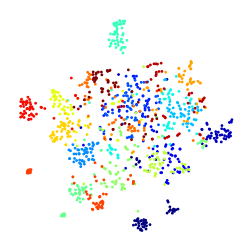

In [138]:


# E_reduced_subset = E_reduced[selected_indices]
y_subset = y[selected_indices]
#
# print(E_reduced.shape)
#
plt.figure(figsize=(3, 3))
plt.scatter(E_reduced[:, 0], E_reduced[:, 1], c=y_subset, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
plt.axis('off')
plt.show()
# plt.figure(figsize=(12, 8))
# plt.scatter(E_reduced_subset[:, 0], E_reduced_subset[:, 1], c=y_subset, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
# plt.axis('off')
# plt.show()


In [76]:
# PRE
# run_id = 'SUB-849'
run_id = 'SUB-928'
path = Path('../data/models/checkpoints', run_id, 'embeddings.pkl')

feature_bank, feature_labels, embedding, targets, label_names = CPUUnpickler(open(path, 'rb')).load()

A = feature_bank.T
U, S, V = torch.pca_lowrank(A, q=20, center=True, niter=10)
# Train
X = U.cpu().numpy()
y = val_labels.cpu().numpy()

print(torch.all(A==0))

# Val
E = ((embedding - A.mean(axis=0)) @ V @ torch.diag(1 / S)).cpu().numpy()
Ey = targets.cpu().numpy()
# E = X
# XE = np.concatenate((X, E))

tsne = TSNE(n_components=2, random_state=42)
E_subset = E[selected_indices]
E_reduced = tsne.fit_transform(E_subset)
t1 = time.time()
#
# X_reduced = XE_reduced[:len(X)]
# E_reduced = XE_reduced[len(X):]


# plt.figure(figsize=(12, 8))
# plt.scatter(E_reduced[:, 0], E_reduced[:, 1], c=y, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
# plt.axis('off')
# plt.show()
# E_reduced_subset = E_reduced[selected_indices]
# y_subset = y[selected_indices]

print(E_reduced.shape)
#

tensor(False)


/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)


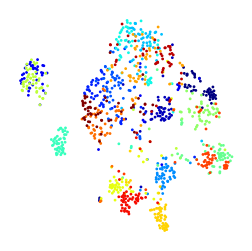

In [77]:

plt.figure(figsize=(3, 3))
plt.scatter(E_reduced[:, 0], E_reduced[:, 1], c=y_subset, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
plt.axis('off')
plt.show()
# plt.figure(figsize=(12, 8))
# plt.scatter(E_reduced_subset[:, 0], E_reduced_subset[:, 1], c=y_subset, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
# plt.axis('off')
# plt.show()

torch.Size([2048])
[80 65 64 55 72  3  4 50 38 66 34 74 32 15 45 77 27 19 44 31]
tensor(False)


/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)


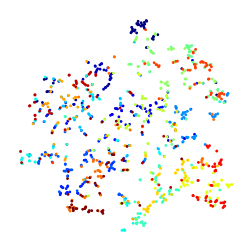

In [141]:


# PRE
# run_id = 'SUB-849'
#     - SUB-997 #0 SUB-993
#     - SUB-1192 #1 SUB-1080
#     - SUB-1194 #2 SUB-1081
#     - SUB-1195 #3 SUB-1082
#     - SUB-1003 #4 SUB-995
run_id = 'SUB-1417'
# run_id = 'SUB-928'
# run_id = 'SUB-997'
# run_id = 'SUB-1192'
# run_id = 'SUB-1194'
# run_id = 'SUB-1195'
# run_id = 'SUB-1003'
path = Path('../data/models/checkpoints', run_id, 'embeddings.pkl')

feature_bank, feature_labels, embedding, targets, label_names = CPUUnpickler(open(path, 'rb')).load()

# val cluster 0 mean
c0_mean = val_embeddings[0][val_cluster_assignments == 0].mean(axis=0)
print(c0_mean.shape)

# means of each class
class_means = []
for i in np.unique(val_labels):
    class_means.append(val_embeddings[0][val_labels == i].mean(axis=0))

# n classes that on average are closest to mean
n = 20
distances = []
for i in range(len(class_means)):
    distances.append(np.linalg.norm(class_means[i] - c0_mean))
distances = np.array(distances)

selected_classes = np.argsort(distances)[:n]
print(selected_classes)



import time
from sklearn.manifold import TSNE

y = val_labels.cpu().numpy()

unique_classes = np.unique(y)
selected_classes = unique_classes[:20]

selected_indices = []

for class_ in selected_classes:
    class_indices = np.where(y == class_)[0]
    if len(class_indices) > 50:
        class_indices = np.random.choice(class_indices, 50, replace=False)
    selected_indices.extend(class_indices)

selected_indices = np.array(selected_indices)

A = feature_bank.T
U, S, V = torch.pca_lowrank(A, q=10, center=True, niter=10)
# Train
X = U.cpu().numpy()
y = val_labels.cpu().numpy()

print(torch.all(A==0))

# Val
E = ((embedding - A.mean(axis=0)) @ V @ torch.diag(1 / S)).cpu().numpy()
Ey = targets.cpu().numpy()
# E = X
# XE = np.concatenate((X, E))

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
E_subset = E[selected_indices]
E_reduced = tsne.fit_transform(E_subset)
t1 = time.time()
#
# X_reduced = XE_reduced[:len(X)]
# E_reduced = XE_reduced[len(X):]


# plt.figure(figsize=(12, 8))
# plt.scatter(E_reduced[:, 0], E_reduced[:, 1], c=y, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
# plt.axis('off')
# plt.show()
# E_reduced_subset = E_reduced[selected_indices]
# y_subset = y[selected_indices]

print(E_reduced.shape)

plt.figure(figsize=(3, 3))
plt.scatter(E_reduced[:, 0], E_reduced[:, 1], c=y_subset, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
plt.axis('off')
plt.show()
#

In [113]:

# plt.figure(figsize=(12, 8))
# plt.scatter(E_reduced_subset[:, 0], E_reduced_subset[:, 1], c=y_subset, cmap='jet', marker='o', s=1.0)
# plt.colorbar()
# plt.axis('off')
# plt.show()